In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


In [2]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

def preprocess_data(df):
    df.drop(index=[0, 1], inplace=True, errors='ignore')
    if 'Price' in df.columns:
        df.rename(columns={'Price': 'Date'}, inplace=True)
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df.dropna(subset=['Date', 'Close'], inplace=True)
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
    df.dropna(subset=['Close'], inplace=True)
    
    return df  # ✅ Must return 3 items


In [3]:
def create_sequences(data, time_step=60):
    X = []
    y = []
    
    for i in range(time_step, len(data)):
        X.append(data[i - time_step:i])  # Taking the last 60 days' closing prices
        y.append(data[i])  # Target: the next day's closing price
    
    X = np.array(X)
    y = np.array(y)
    
    return X, y


In [4]:
def build_model(input_shape):
    model = Sequential()

    # Adding LSTM layers with Dropout
    model.add(LSTM(units=100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))  # Dropout layer to prevent overfitting

    model.add(LSTM(units=100, return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(units=50))
    model.add(Dropout(0.2))

    # Dense layer to output a single value
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    return model


# AAPL

In [13]:
import os,sys
sys.path.append(os.path.abspath('..'))

In [18]:
path = r'C:\Complete Project\Stock-Price-Prediction-using-LSTM\historical_data\AAPL.csv'

In [19]:
data = pd.read_csv(path)

In [20]:
preprocess_data(data)

,Unnamed: 0,Date,Close,High,Low,Open,Volume
2,4,2004-01-06,0.332383,0.337349,0.326666,0.334791,509348000
3,5,2004-01-07,0.339907,0.343519,0.329976,0.332534,586874400
4,6,2004-01-08,0.351493,0.357061,0.340810,0.343669,460303200
5,7,2004-01-09,0.346076,0.363079,0.342916,0.349537,427459200
6,8,2004-01-12,0.357061,0.361123,0.347581,0.349838,487547200
...,...,...,...,...,...,...,...
5279,5281,2024-12-23,254.989655,255.369227,253.171646,254.490204,40858800
5280,5282,2024-12-24,257.916443,257.926411,255.009620,255.209412,23234700
5281,5283,2024-12-26,258.735504,259.814335,257.347047,257.906429,27237100
5282,5284,2024-12-27,255.309296,258.415896,252.782075,257.546826,42355300


In [21]:
# Extract closing price for simplicity
data = data[['Close']]

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [22]:
# Create sequences of data
X, y = create_sequences(scaled_data)

# Reshape X to be 3D (samples, timesteps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)

In [23]:
# Split the data into training and validation sets (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

In [24]:
# Build the model
model = build_model(X_train.shape[1:])

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,  # Number of epochs to train
                    batch_size=32,  # Batch size
                    callbacks=[early_stopping],  # Early stopping callback
                    verbose=1)


Epoch 1/50


C:\Users\POOJA\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


131/131 ━━━━━━━━━━━━━━━━━━━━ 16s 81ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - loss: 2.0033e-04 - val_loss: 0.0018
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - loss: 1.5201e-04 - val_loss: 8.5293e-04
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - loss: 1.7979e-04 - val_loss: 7.9231e-04
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - loss: 1.4428e-04 - val_loss: 0.0018
Epoch 6/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - loss: 1.8108e-04 - val_loss: 7.1338e-04
Epoch 7/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 1.1345e-04 - val_loss: 0.0019
Epoch 8/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - loss: 1.3369e-04 - val_loss: 7.9102e-04
Epoch 9/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - loss: 1.4771e-04 - val_loss: 0.0040
Epoch 10/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - loss: 1.2501e-04 - val_loss: 4.9876e-04
Epoch 11/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - loss: 1.1015e-04 - val_lo

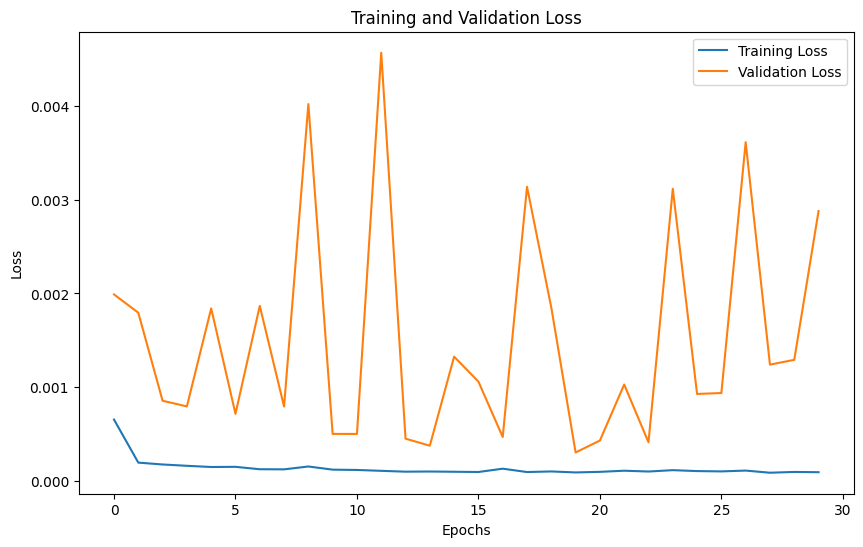

In [25]:
# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [26]:
# Save the trained model
model.save(f'model/AAPL_model.h5')
print("Model saved successfully.")


Model saved successfully.


In [27]:
# Evaluate the model on validation data
val_loss = model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss}')


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2.5421e-04
Validation Loss: 0.00030037894612178206


In [28]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model(f'model/AAPL_model.h5')

# Make predictions with the loaded model
loaded_model_predictions = loaded_model.predict(X_val)


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step


# TSLA

In [82]:
path = 'data/historical/TSLA.csv'

In [83]:
data = pd.read_csv(path)

In [84]:
preprocess_data(data)

,Date,Close,High,Low,Open,Volume
2,2010-06-29,1.592667,1.6666669845581055,1.1693329811096191,1.2666670083999634,281494500
3,2010-06-30,1.588667,2.0280001163482666,1.553333044052124,1.7193330526351929,257806500
4,2010-07-01,1.464000,1.7280000448226929,1.3513330221176147,1.6666669845581055,123282000
5,2010-07-02,1.280000,1.5399999618530273,1.24733304977417,1.5333329439163208,77097000
6,2010-07-06,1.074000,1.3333330154418945,1.0553330183029175,1.3333330154418945,103003500
...,...,...,...,...,...,...
3648,2024-12-23,430.600006,434.510009765625,415.4100036621094,431.0,72698100
3649,2024-12-24,462.279999,462.7799987792969,435.1400146484375,435.8999938964844,59551800
3650,2024-12-26,454.130005,465.3299865722656,451.0199890136719,465.1600036621094,76366400
3651,2024-12-27,431.660004,450.0,426.5,449.5199890136719,82666800


In [85]:
# Extract closing price for simplicity
data = data[['Close']]

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [86]:
# Create sequences of data
X, y = create_sequences(scaled_data)

# Reshape X to be 3D (samples, timesteps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)

In [87]:
# Split the data into training and validation sets (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

In [88]:
# Build the model
model = build_model(X_train.shape[1:])

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,  # Number of epochs to train
                    batch_size=32,  # Batch size
                    callbacks=[early_stopping],  # Early stopping callback
                    verbose=1)


Epoch 1/50


C:\Users\POOJA\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - loss: 0.0054 - val_loss: 0.0039
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 0.0011 - val_loss: 0.0029
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 7.0367e-04 - val_loss: 0.0027
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 6.3774e-04 - val_loss: 0.0030
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 6.9160e-04 - val_loss: 0.0038
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - loss: 7.1277e-04 - val_loss: 0.0019
Epoch 7/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 7.2643e-04 - val_loss: 0.0019
Epoch 8/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 4.6626e-04 - val_loss: 0.0019
Epoch 9/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 5.7116e-04 - val_loss: 0.0016
Epoch 10/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 6.7267e-04 - val_loss: 0.0021
Epoch 11/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 5.5268e-04 - val_loss: 0.0017
Epoch 12/50
90/90 ━━━━━━━━━━━━━━━━━━━━

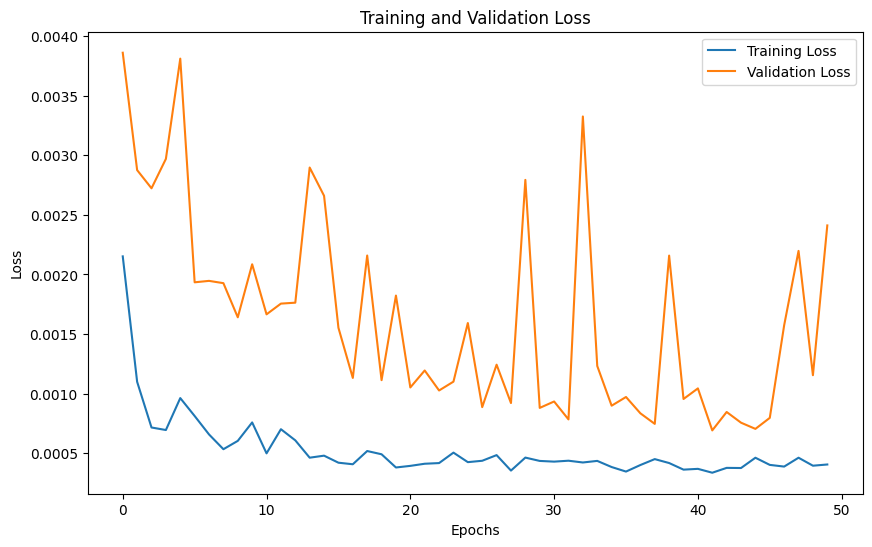

In [89]:
# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [90]:
# Save the trained model
model.save(f'model/TSLA_model.h5')
print("Model saved successfully.")


Model saved successfully.


In [91]:
# Evaluate the model on validation data
val_loss = model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss}')


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.4592e-04
Validation Loss: 0.0006917018326930702


In [92]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model(f'model/AAPL_model.h5')

# Make predictions with the loaded model
loaded_model_predictions = loaded_model.predict(X_val)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
